In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from tqdm import tqdm
import warnings


In [11]:
df = pd.read_csv('glif.csv', low_memory=False)
# Filter for valid landslide entries
df = df.query("(landslide == 0) | (landslide == 1 & (severity == 'small' | severity == 'medium' | severity == 'large'))")
num_landslides = df.landslide.value_counts()[1]

count = 0
to_drop = []
for idx, row in tqdm(df.iterrows(), total=len(df), leave=False):
    if row.landslide == 0 and count <= num_landslides:
        count += 1
    if row.landslide == 0 and count > num_landslides:
        to_drop.append(idx)
df.drop(to_drop, inplace=True)

df = shuffle(df)
df.reset_index(inplace=True, drop=True)
print('loaded')

loaded


In [12]:
df.landslide.describe()

count    17380.000000
mean         0.500000
std          0.500014
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: landslide, dtype: float64

### loading to X, y

In [24]:
X = df.copy()
y = X.landslide
columns = []
for i in range(9, 4, -1):
    columns.append(f'ARI{i}')
    columns.append(f'air{i}')
columns.extend(['slope', 'forest', 'osm', 'lithology'])
X = X[columns]


In [26]:
# Split data into train, validation and test sets
TEST_SIZE = 0.2
VAL_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VAL_SIZE)


In [27]:
num = len(X_train.columns)

categorical = [num-1]
numerical = [i for i in range(num-1)]

scaler = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OrdinalEncoder(), categorical)
])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


In [33]:
len(X_train), len(X_test), len(X_val)

(12513, 3476, 1391)

In [34]:
len(y_train), len(y_test), len(y_val)

(12513, 3476, 1391)

### Trying SVC

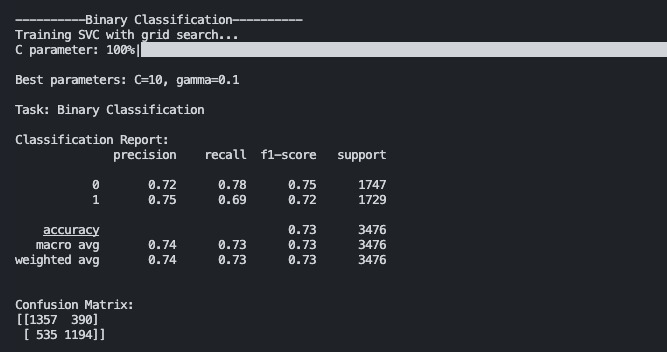

In [39]:
from IPython.display import Image
Image(filename="figures/img.jpeg")

doing grid search is very slow, so we did it separately in a different script. So that incase we need to rerun cells of this notebook, we don't have to wait for the grid search to complete.

In [35]:
pca = PCA(0.9)  # Keep 90% of variance
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

print("Training SVC with grid search...")
best_c = 0
best_gamma = 0
highest_score = 0

# NOTE: Through Previous Testing (as shown in SS, we concluded that gamma = 0.1 is the best)
C_range = [10] 
gamma_range = [0.1]

for c in tqdm(C_range, desc="C parameter"):
    for gamma in gamma_range:
        svc = SVC(kernel='rbf', gamma=gamma, C=c, probability=True)
        svc.fit(X_train, y_train)
        score = accuracy_score(y_val, svc.predict(X_val))
        if score > highest_score:
            best_c = c
            best_gamma = gamma
            highest_score = score

# Train final model with best parameters
print(f"\nBest parameters: C={best_c}, gamma={best_gamma}")
final_model = SVC(kernel='rbf', gamma=best_gamma, C=best_c, probability=True)
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Training SVC with grid search...


C parameter: 100%|██████████| 1/1 [00:10<00:00, 10.62s/it]



Best parameters: C=10, gamma=0.1

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1744
           1       0.73      0.69      0.71      1732

    accuracy                           0.72      3476
   macro avg       0.72      0.72      0.72      3476
weighted avg       0.72      0.72      0.72      3476


Confusion Matrix:
[[1305  439]
 [ 541 1191]]


### Trying KNN

In [36]:
# Apply KNN classifier
from sklearn.neighbors import KNeighborsClassifier


print("Training KNN...")

# Grid search for best k
k_range = range(1, 50, 2)
best_k = 0
best_score = 0

for k in tqdm(k_range, desc="k parameter"):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = accuracy_score(y_val, knn.predict(X_val))
    if score > best_score:
        best_k = k
        best_score = score

print(f"\nBest k value: {best_k}")

# Train final model with best k
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = final_knn.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))


Training KNN...


k parameter: 100%|██████████| 25/25 [00:00<00:00, 26.52it/s]



Best k value: 17

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1744
           1       0.72      0.67      0.70      1732

    accuracy                           0.71      3476
   macro avg       0.71      0.71      0.71      3476
weighted avg       0.71      0.71      0.71      3476


Confusion Matrix:
[[1291  453]
 [ 565 1167]]
